In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

pd.set_option('display.float_format', lambda x: '%.10f' % x)
from sklearn.preprocessing import normalize
import numpy as np

from scipy.sparse import hstack, vstack

from sklearn.cluster import MiniBatchKMeans

from sklearn.preprocessing import LabelEncoder,OneHotEncoder

import warnings
warnings.filterwarnings('ignore')
from sklearn.pipeline import Pipeline, make_pipeline

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from joblib import dump, load
import pickle

from sklearn.metrics import accuracy_score

from catboost import CatBoostClassifier, Pool

from sklearn.model_selection import train_test_split

## Коллекционируем данные 

# train, test_2019, test_2020

In [ ]:
%%time
train = []
years = ['2015', '2016', '2017', '2018', '2019']

for year in years:
    tmp = pd.read_csv(f'./train/train_{year}.csv')
    tmp['year'] = year
    train.append (tmp)
del tmp
train = pd.concat(train)

# test 2019
test_2019 = []
years = ['2015', '2016', '2017', '2018']

for year in years:
    tmp = pd.read_csv(f'./test/test 2019/test_{year}.csv')
    tmp['year'] = year
    test_2019.append (tmp)
del tmp
test_2019 = pd.concat(test_2019)

# test 2020
test_2020 = []
years = ['2015', '2016', '2017', '2018', '2019']

for year in years:
    tmp = pd.read_csv(f'./test/test 2020/test_{year}.csv')
    tmp['year'] = year
    test_2020.append (tmp)
del tmp
test_2020 = pd.concat(test_2020)

CPU times: user 36.9 s, sys: 2.24 s, total: 39.1 s
Wall time: 21.6 s


In [ ]:
%%time

#  LabelEncoder :
le = LabelEncoder()
le.fit(np.append(train['CODE_CULTU'].unique(), test_2019['CODE_CULTU'].unique(),))

CPU times: user 673 ms, sys: 39.3 ms, total: 712 ms
Wall time: 494 ms


LabelEncoder()

In [ ]:
%%time

train['CODE_CULTU'] = le.transform(train['CODE_CULTU'])
test_2019['CODE_CULTU'] = le.transform(test_2019['CODE_CULTU'])
test_2020['CODE_CULTU'] = le.transform(test_2020['CODE_CULTU'])

train = train.pivot(index='centroid', columns='year', values=['CODE_CULTU','CODE_GROUP'])
train.columns = ['CODE_CULTU_'+ x for x in years] + ['CODE_GROUP_'+ x for x in years]
train.reset_index(inplace=True)

test_2019 = test_2019.pivot(index='centroid', columns='year', values=['CODE_CULTU','CODE_GROUP'])
test_2019.columns = ['CODE_CULTU_'+ x for x in years[:-1]] + ['CODE_GROUP_'+ x for x in years[:-1]]
test_2019.reset_index(inplace=True)

test_2020 = test_2020.pivot(index='centroid', columns='year', values=['CODE_CULTU','CODE_GROUP'])
test_2020.columns = ['CODE_CULTU_'+ x for x in years] + ['CODE_GROUP_'+ x for x in years]
test_2020.reset_index(inplace=True)

CPU times: user 27.5 ms, sys: 1.66 ms, total: 29.1 ms
Wall time: 27.9 ms


In [ ]:
train.columns, test_2019.columns, test_2020.columns

(Index(['centroid', 'CODE_CULTU_2015', 'CODE_CULTU_2016', 'CODE_CULTU_2017',
        'CODE_CULTU_2018', 'CODE_CULTU_2019', 'CODE_GROUP_2015',
        'CODE_GROUP_2016', 'CODE_GROUP_2017', 'CODE_GROUP_2018',
        'CODE_GROUP_2019'],
       dtype='object'),
 Index(['centroid', 'CODE_CULTU_2015', 'CODE_CULTU_2016', 'CODE_CULTU_2017',
        'CODE_CULTU_2018', 'CODE_GROUP_2015', 'CODE_GROUP_2016',
        'CODE_GROUP_2017', 'CODE_GROUP_2018'],
       dtype='object'),
 Index(['centroid', 'CODE_CULTU_2015', 'CODE_CULTU_2016', 'CODE_CULTU_2017',
        'CODE_CULTU_2018', 'CODE_CULTU_2019', 'CODE_GROUP_2015',
        'CODE_GROUP_2016', 'CODE_GROUP_2017', 'CODE_GROUP_2018',
        'CODE_GROUP_2019'],
       dtype='object'))

# centroid - > x, y (м)



In [ ]:
%%time
def centroid_x_y(df):
    df[['x', 'y']] = df['centroid'].str.split('[^\d\.]+', expand=True)[[1,2]]
    df['x'], df['y'] = df['x'].astype('float64'), df['y'].astype('float64')
    return df.drop(columns = ['centroid'])

train, test_2019, test_2020 = centroid_x_y(train), centroid_x_y(test_2019), centroid_x_y(test_2020)

CPU times: user 19.2 s, sys: 660 ms, total: 19.8 s
Wall time: 16.7 s


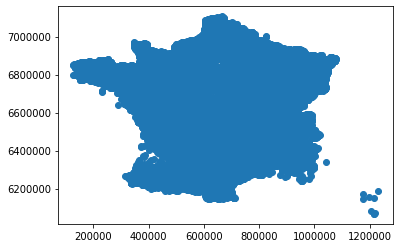

In [ ]:
# визуализируем 1% от centroid
unique_areas = train[['x', 'y']].drop_duplicates().sample(frac = 0.01)
plt.scatter(unique_areas['x'], unique_areas['y'], )

Видим почти полное заполнение территории Франции

Будем кластеризовать по координатам x, y + векторам из истории высадки культур.

![image.png](attachment:image.png)

![image.png](attachment:image.png)

## возьмем 64 кластеров так, что средняя площадь кластера будет 10000 км^2 или квадрат со стороной 100 км

In [ ]:
%%time
# векторизуем:
train['concat'] = ''
for y in ['CODE_CULTU_'+x for x in years]:
    train['concat'] += ' '
    train['concat'] += train[y].astype('str')

vect = TfidfVectorizer(lowercase = False, use_idf=False)
vect.fit(train['concat'].values)

X = vect.transform(train['concat'].values)
print(X.shape)

# Кластеризуем:
n_clusters = 64
CL = MiniBatchKMeans(n_clusters = n_clusters)
CL.fit(X)
train['CL'] = CL.predict(X)

(3614804, 302)
CPU times: user 55.6 s, sys: 1.45 s, total: 57 s
Wall time: 56.8 s


## Также добавим 64 кластера по географии x,y:

In [ ]:
%%time
# Кластеризуем:
n_clusters = 64
CLG = MiniBatchKMeans(n_clusters = n_clusters)
CLG.fit(train[['x', 'y']])
train['CLG'] = CLG.predict(train[['x', 'y']])

CPU times: user 22.6 s, sys: 398 ms, total: 23 s
Wall time: 21.9 s


## Смотрим, как много культур включает каждый кластер 

In [ ]:
# 0.95 - персентиль:

PST = 0.95
clusters_distr = []
for cl in range(0, n_clusters ):
    tmp = pd.DataFrame(train[train ['CL'] == cl][['CODE_CULTU_'+x for x in years]].values.flatten())
    CNT = tmp.shape[0]
    tmp = pd.DataFrame(tmp[0].value_counts())
    tmp['cumsum'] = tmp[0].cumsum()
    CNT_CODE_CULTU = len(tmp[tmp['cumsum'] < CNT*0.95].index)+1
#     print(f'cl:{cl}, CNT_CODE_CULTU:{CNT_CODE_CULTU}, CNT: {CNT}')
    clusters_distr.append([cl, CNT_CODE_CULTU,CNT])
    
clusters_distr = pd.DataFrame(clusters_distr, columns = ['cl', 'CNT_CODE_CULTU', 'CNT'])

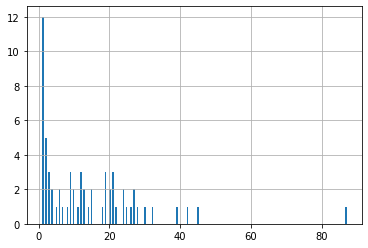

In [ ]:
clusters_distr.CNT_CODE_CULTU.hist(bins=200)

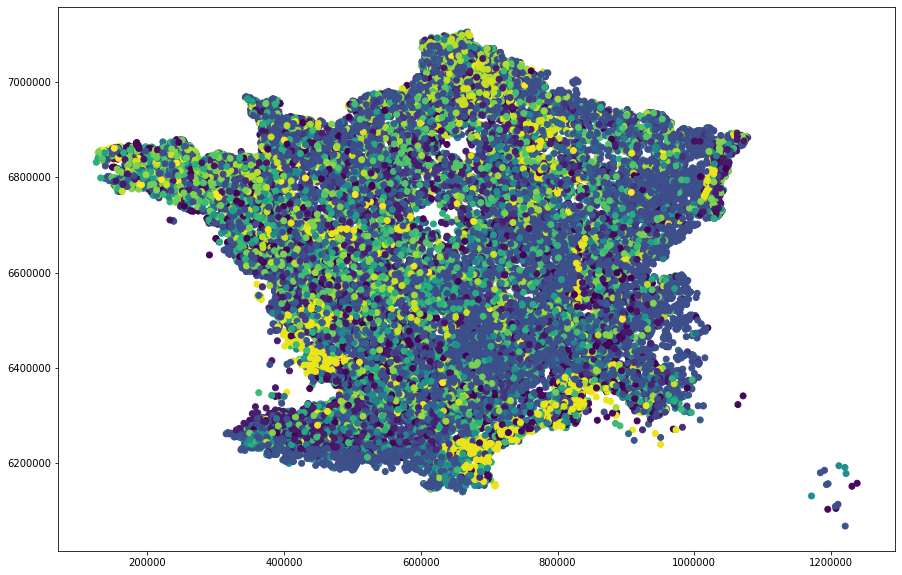

In [ ]:
# визуализируем 1% от centroid
unique_areas = train[['x', 'y', 'CL']].drop_duplicates().sample(frac = 0.01)
plt.figure(figsize =(15, 10))
plt.scatter(unique_areas['x'], unique_areas['y'], c=unique_areas.CL.astype(float))

## Кластеры географически частично перемешаны, но есть например 16 кластеров с 1 культурой

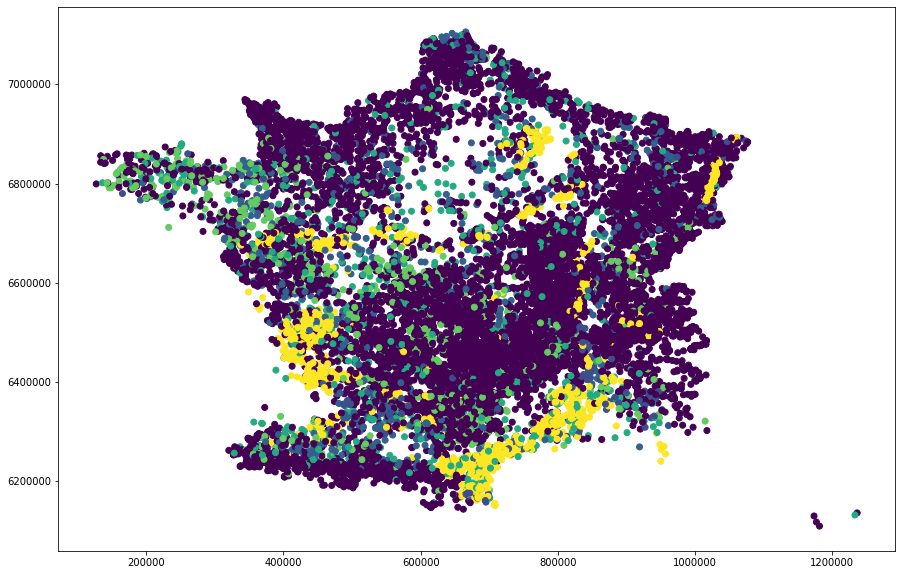

In [ ]:
# визуализируем 1% от centroid
# unique_areas = train[['x', 'y', 'CL']].sample(frac = 0.01)
plt.figure(figsize =(15, 10))
# plt.scatter(unique_areas['x'], unique_areas['y'],)

clusters = clusters_distr[clusters_distr.CNT_CODE_CULTU ==1].cl.values
unique_areas = train[train['CL'].isin(clusters)][['x', 'y', 'CL']].sample(frac = 0.01)
color = unique_areas.CL.astype(float)
plt.scatter(unique_areas['x'], unique_areas['y'], c=color, )

## test_2019, test_2020 - предобработаем  тем же образом

In [ ]:
test_2019['concat'] = ''
for year in ['CODE_CULTU_'+x for x in years][:-1]:
    test_2019['concat'] += ' '
    test_2019['concat'] += test_2019[year].astype('str')
X = vect.transform(test_2019['concat'].values)
print(X.shape)

# Получаем номер кластера:
test_2019['CL'] = CL.predict(X)

(401645, 302)


In [ ]:
# ГЕОГРАФИЧЕСКИЕ КЛАСТЕРА :
test_2019['CLG'] = CLG.predict(test_2019[['x','y']])

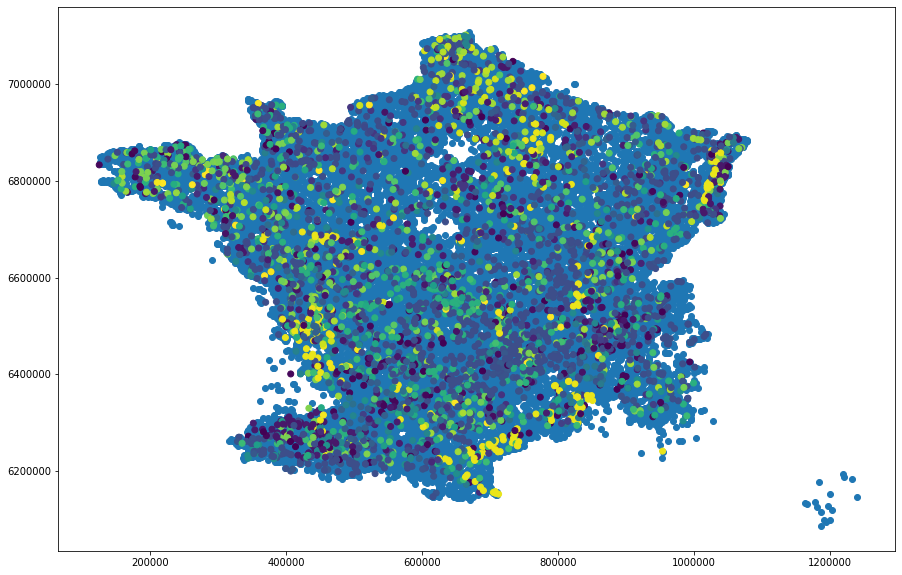

In [ ]:
# визуализируем 1% от centroid
unique_areas = train[['x', 'y', 'CL']].sample(frac = 0.01)
plt.figure(figsize =(15, 10))
plt.scatter(unique_areas['x'], unique_areas['y'],)
unique_areas = test_2019[['x', 'y', 'CL']].sample(frac = 0.01)
plt.scatter(unique_areas['x'], unique_areas['y'], c=unique_areas.CL.astype(float))

## видно, что centroid в test_2019 - взяты случайно из всех областей

In [ ]:
test_2020['concat'] = ''
for year in ['CODE_CULTU_'+x for x in years]:
    test_2020['concat'] += ' '
    test_2020['concat'] += test_2020[year].astype('str')
    
X = vect.transform(test_2020['concat'].values)
print(X.shape)

# Получаем номер кластера:
test_2020['CL'] = CL.predict(X)

(27, 302)


In [ ]:
# ГЕОГРАФИЧЕСКИЕ КЛАСТЕРА :
test_2020['CLG'] = CLG.predict(test_2020[['x','y']])

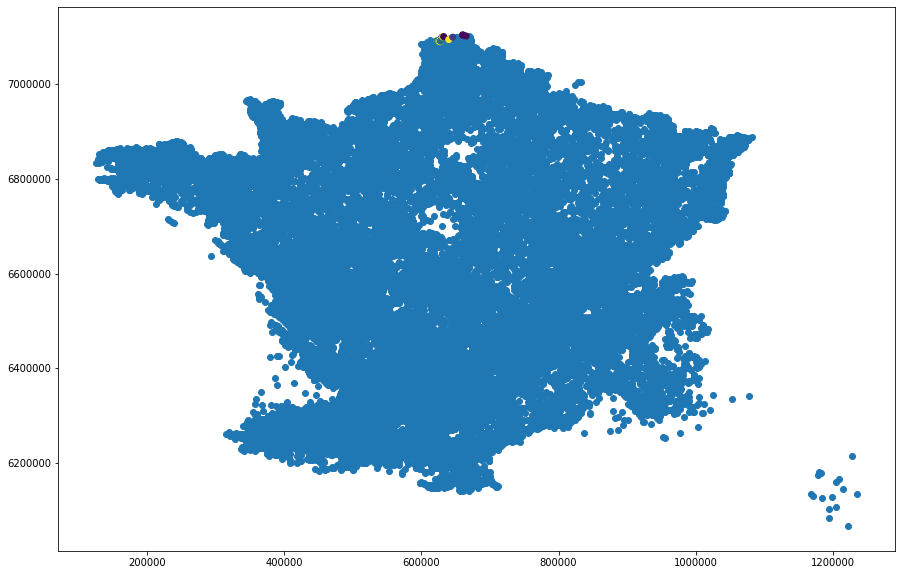

In [ ]:
# визуализируем 1% от centroid
unique_areas = train[['x', 'y', 'CL']].sample(frac = 0.01)
plt.figure(figsize =(15, 10))
plt.scatter(unique_areas['x'], unique_areas['y'],)

unique_areas = test_2020[['x', 'y', 'CL']]
plt.scatter(unique_areas['x'], unique_areas['y'], c=unique_areas.CL.astype(float))

In [ ]:
# save

with open('train.pickle', 'wb') as f:
    pickle.dump(train, f)
with open('test_2019.pickle', 'wb') as f:
    pickle.dump(test_2019, f)
with open('test_2020.pickle', 'wb') as f:
    pickle.dump(test_2020, f) 

In [ ]:
train.columns

Index(['CODE_CULTU_2015', 'CODE_CULTU_2016', 'CODE_CULTU_2017',
       'CODE_CULTU_2018', 'CODE_CULTU_2019', 'CODE_GROUP_2015',
       'CODE_GROUP_2016', 'CODE_GROUP_2017', 'CODE_GROUP_2018',
       'CODE_GROUP_2019', 'x', 'y', 'concat', 'CL', 'CLG'],
      dtype='object')

In [ ]:
test_2019.columns

Index(['CODE_CULTU_2015', 'CODE_CULTU_2016', 'CODE_CULTU_2017',
       'CODE_CULTU_2018', 'CODE_GROUP_2015', 'CODE_GROUP_2016',
       'CODE_GROUP_2017', 'CODE_GROUP_2018', 'x', 'y', 'concat', 'CL', 'CLG'],
      dtype='object')

In [ ]:
test_2020.columns

Index(['CODE_CULTU_2015', 'CODE_CULTU_2016', 'CODE_CULTU_2017',
       'CODE_CULTU_2018', 'CODE_CULTU_2019', 'CODE_GROUP_2015',
       'CODE_GROUP_2016', 'CODE_GROUP_2017', 'CODE_GROUP_2018',
       'CODE_GROUP_2019', 'x', 'y', 'concat', 'CL', 'CLG'],
      dtype='object')

## Классификация 

# 1.  Обучаемся на годах '2015', '2016', '2017' из train, target => '2018', проверяем на test_2019



In [ ]:
# load
with open('train.pickle', 'rb') as f:
    train = pickle.load(f)
with open('test_2019.pickle', 'rb') as f:
    test_2019 = pickle.load(f)
with open('test_2020.pickle', 'rb') as f:
    test_2020 = pickle.load(f)

In [ ]:
%%time

cat_features = ['CODE_CULTU_2015', 'CODE_CULTU_2016', 'CODE_CULTU_2017', \
                'CODE_GROUP_2015','CODE_GROUP_2016', 'CODE_GROUP_2017',\
                'CLG']

train[cat_features] = train[cat_features].astype('category')
test_2019[cat_features] = test_2019[cat_features].astype('category')

target = 'CODE_CULTU_2018'

lg = LGBMClassifier(learning_rate = 0.05)

for cl in test_2019['CL'].sort_values().unique():
    print(f'cluster_n={cl}, ')
    train_condition, test_condition = train.CL == cl, test_2019.CL == cl

    tr, y_tr = train[train_condition][cat_features], train[train_condition][[target]]
    tst, y_tst = test_2019[test_condition][cat_features], test_2019[test_condition][[target]]
#     1 ил 2 класса:
    tr_classes= y_tr[target].value_counts().keys()
    print(f'n- classes: {len(tr_classes)}')
    if len(tr_classes) <= 2:
        predicted = [tr_classes[0]] * len(y_tst)
    else:
        lg.fit(tr, y_tr)
        predicted = lg.predict(tst)
    
    print (f'test_size={len(y_tst)}, accuracy_score={accuracy_score(predicted, y_tst)}' )
    test_2019.loc[test_condition, 'CODE_CULTU_2018_p'] = predicted

96
cluster_n=0, test_size=7130, accuracy_score=0.8943899018232819
234
cluster_n=1, test_size=12824, accuracy_score=0.7923424828446662
122
cluster_n=2, test_size=3137, accuracy_score=0.7631495058973542
101
cluster_n=3, test_size=4113, accuracy_score=0.8050085096036956
159
cluster_n=4, test_size=14172, accuracy_score=0.7750493931696303
98
cluster_n=5, test_size=14384, accuracy_score=0.942714126807564
124
cluster_n=6, test_size=3250, accuracy_score=0.5987692307692307
51
cluster_n=7, test_size=1323, accuracy_score=0.7384731670445956
76
cluster_n=8, test_size=913, accuracy_score=0.5366922234392114
108
cluster_n=9, test_size=3624, accuracy_score=0.7560706401766004
149
cluster_n=10, test_size=13661, accuracy_score=0.7584364248590879
88
cluster_n=11, test_size=1526, accuracy_score=0.7640891218872871
127
cluster_n=12, test_size=2246, accuracy_score=0.5512021371326803
105
cluster_n=13, test_size=336, accuracy_score=0.6964285714285714
112
cluster_n=14, test_size=8255, accuracy_score=0.77347062386

In [ ]:
accuracy_score(test_2019['CODE_CULTU_2018_p'], test_2019['CODE_CULTU_2018'])

0.8546253532348218

# 2.  Обучаемся на годах '2015', '2016', '2017', '2018' train, target => '2019', проверяем на test_2020


In [ ]:
%%time

cat_features = ['CODE_CULTU_2015', 'CODE_CULTU_2016', 'CODE_CULTU_2017', 'CODE_CULTU_2018',\
                'CODE_GROUP_2015','CODE_GROUP_2016', 'CODE_GROUP_2017', 'CODE_GROUP_2018',\
                'CLG']

train[cat_features] = train[cat_features].astype('category')
test_2020[cat_features] = test_2020[cat_features].astype('category')

target = 'CODE_CULTU_2019'

lg = LGBMClassifier(learning_rate = 0.05)

for cl in test_2020['CL'].sort_values().unique():
    print(f'cluster_n={cl}, ')
    train_condition, test_condition = train.CL == cl, test_2020.CL == cl

    tr, y_tr = train[train_condition][cat_features], train[train_condition][[target]]
    tst, y_tst = test_2020[test_condition][cat_features], test_2020[test_condition][[target]]
#     1 ил 2 класса:
    tr_classes= y_tr[target].value_counts().keys()
    print(f'n- classes: {len(tr_classes)}')
    if len(tr_classes) <= 2:
        predicted = [tr_classes[0]] * len(y_tst)
    else:
        lg.fit(tr, y_tr)
        predicted = lg.predict(tst)
    
    print (f'test_size={len(y_tst)}, accuracy_score={accuracy_score(predicted, y_tst)}' )
    test_2020.loc[test_condition, 'CODE_CULTU_2019_p'] = predicted

n- classes: 111
cluster_n=0, test_size=1, accuracy_score=1.0
n- classes: 211
cluster_n=1, test_size=3, accuracy_score=1.0
n- classes: 113
cluster_n=5, test_size=1, accuracy_score=1.0
n- classes: 124
cluster_n=10, test_size=3, accuracy_score=0.6666666666666666
n- classes: 119
cluster_n=20, test_size=1, accuracy_score=1.0
n- classes: 31
cluster_n=29, test_size=9, accuracy_score=1.0
n- classes: 151
cluster_n=54, test_size=4, accuracy_score=1.0
n- classes: 76
cluster_n=57, test_size=3, accuracy_score=1.0
n- classes: 81
cluster_n=59, test_size=2, accuracy_score=0.5
CPU times: user 23min 57s, sys: 12.2 s, total: 24min 9s
Wall time: 2min 6s


In [ ]:
accuracy_score(test_2020['CODE_CULTU_2019_p'], test_2020['CODE_CULTU_2019'])

0.9259259259259259